# Business license cleanup

This notebook what we need to do to clean the business license data from the [Vancouver Open Data Portal](https://opendata.vancouver.ca) so we can analyze business survival/failure and build a model to predict the likelihood of a new business surviving.

TODO:

- Drop `Status == 'Cancelled'`
- Drop `BusinessType in ['Exhibitions/Shows/Concerts', 'Temp Liquor Licence Amendment']` and any other one-off / temporary business categories
- Drop `Live-aboards` type as well as they are basically all duplicated.
- Figure out how to account for business that have shuttered, but did not inform the city (probably something like if a business is there one year, gone the next, assume it's out of business)

Extension ideas:

* incorporate property tax data

The first thing we will do[^1] is load our data and take a cursory look at what's in it:

[^1] When I say first thing, what I really mean is *first thing in this blog post*. I did a fair amount of random poking around just to figure out what cleaning needed to be done.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/2020.11.15-business-licences.csv', sep=';')
df.info()

/Users/colinspear/.venv/business_licenses/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509444 entries, 0 to 509443
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   FOLDERYEAR             509444 non-null  int64  
 1   LicenceRSN             509444 non-null  int64  
 2   LicenceNumber          509444 non-null  object 
 3   LicenceRevisionNumber  509444 non-null  int64  
 4   BusinessName           493514 non-null  object 
 5   BusinessTradeName      207726 non-null  object 
 6   Status                 509444 non-null  object 
 7   IssuedDate             424090 non-null  object 
 8   ExpiredDate            423765 non-null  object 
 9   BusinessType           509444 non-null  object 
 10  BusinessSubType        277373 non-null  object 
 11  Unit                   136789 non-null  object 
 12  UnitType               136748 non-null  object 
 13  House                  286350 non-null  object 
 14  Street                 286363 non-nu

So we've got 24 columns and about 500k observations. We have information about when a business licence was issued, it's status, when it expired, it's location, size, type. Looks fairly promising so far.

## Identify businesses through time

According to the [documentation](https://opendata.vancouver.ca/explore/dataset/business-licences/information/?disjunctive.status&disjunctive.businesssubtype), `LicenceRSN` is the *unique identifier for each business licence generated by the system*. 

As someone who came to this project knowing nothing about how the Vancouver Business Licencing process works, I assumed that a when a business renewed its licencse (this must happen yearly), it would retain the same license number which would simply get updated. This would have been great, because then we could have just used `LicenceRSN` to identify our business. 

As it turns out, each time a business renews their license, they get a brand new `LicenceRSN`. Ideally we would have a `BusinessID` column that would give us a unique identifier for each business. Unfortunately that's not the case, so we are going to have to make some (hopefully reasonable) assumptions and make one for ourselves. `BusinessName` seems like a good place to start.

In [2]:
df = df.loc[df['Province']=='BC']
df = df.loc[df['BusinessName'].notnull()]

In [3]:
df.shape

(490815, 24)

In [8]:
id_cols = ['BusinessName', 'BusinessTradeName', 'BusinessType', 'BusinessSubType']

for col in id_cols + ['House', 'Street', 'City', 'PostalCode', 'LocalArea']:
    df[col] = df[col].replace(np.nan, '')
    df[col] = df[col].replace('NaN', '')

In [9]:
# df['BusinessName'].replace(np.nan, -1)
df['name_id'] = df.groupby(id_cols).ngroup()
df['name_year_id'] = df.groupby(id_cols + ['FOLDERYEAR']).ngroup()
df['name_code_id'] = df.groupby(id_cols + ['PostalCode']).ngroup()
df['name_code_year_id'] = df.groupby(id_cols + ['FOLDERYEAR', 'PostalCode']).ngroup()
df['name_address_id'] = df.groupby(id_cols + ['House', 'Street', 'City', 'PostalCode', 'LocalArea']).ngroup()
df['name_address_year_id'] = df.groupby(id_cols + ['FOLDERYEAR', 'House', 'Street', 'City', 'PostalCode', 'LocalArea']).ngroup()
# df['id'] = df['id'].replace(-1, np.nan)

In [10]:
for var in ['name_year_id', 'name_code_year_id', 'name_address_year_id']:
    print(len(df[var].unique()))

461196
477565
483174


As we add more columns to our identification, we get more unique values (naturally). On the one hand this is good because we get to keep more data for our analysis, on the other hand we will end up misidentifying a business that changed address as a unique business. I am going to choose to go with the id that gives us the most unique values (`name_address_id`), then work backward to find any businesses that changed address.

Even with the most detailed id, there are almost 30,000 licences that are not unique by year. We'll take a look at these to see if we can do anything about this. We'll be able to save some of these with the `LicenceRevisionNumber` column, but we will undoubtedly have to throw some out that we just aren't able to distinguish.

As with any analysis, there is always a trade-off between time and perfection. There are a lot of ways people refer to this (analysis paralysis, 80-20 rule, etc.) and it is an ever-present menace. There will always be little rabbit holes to go down, curiosities, inexplicable cases that "maybe if I just dig a little deeper, I can explain!!!". It's up to you as the analyst (or me in this case) to decide what is a good use of your time. **This. Is. Hard.** Always. Personally I have the attention span of a two year old, so I am always having to drag myself back to ask myself if what I am doing is likely to have a material impact on the analysis or if I am simply chasing something shiny. 

With that in mind, I am going to restrict myself to 1) finding address change cases and 2) finding licence revisions for uniquely identified companies. I'm sure there will still be duplicates after this. If I want to be super careful, I can compare features (`Status`, `NumberofEmployees`, etc.) of the licences I am throwing out to the licences I am keeping to see if they differ in any substantial way. Let's start with 2).

In [11]:
df['id'] = df['name_address_id']
df['year_id'] = df['name_address_year_id']

df = df.drop(['name_id', 'name_year_id', 'name_code_id', 'name_code_year_id', 'name_address_id', 'name_address_year_id'], axis=1)

In [77]:
print(len(df['id'].unique()))
print(len(df['year_id'].unique()))

161396
483174


In [13]:
year_duplicates = df.loc[df['year_id'].duplicated(keep=False)]

year_duplicates.sort_values(['id', 'FOLDERYEAR', 'LicenceRevisionNumber'])[:20]

,FOLDERYEAR,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,...,Province,Country,PostalCode,LocalArea,NumberofEmployees,FeePaid,ExtractDate,Geom,id,year_id
131643,15,2368620,15-138899,0,(Adam Masztalar),Rush Mechanical,Issued,2014-11-26T15:53:20-08:00,2015-12-31,Plumber,...,BC,CA,,,0.0,133.0,2019-07-21T13:48:02-07:00,NaN,109,320
132529,15,2408214,15-162102,0,(Adam Masztalar),Rush Mechanical,Pending,NaN,NaN,Plumber,...,BC,CA,,,0.0,NaN,2019-07-21T13:48:03-07:00,NaN,109,320
340404,19,3225888,19-100616,0,(Adamo Porco),,Issued,2018-11-02T14:55:55-07:00,2019-12-31,Contractor,...,BC,CA,,Renfrew-Collingwood,0.0,182.0,2020-11-01T02:32:32-08:00,NaN,127,371
371088,19,3303415,19-167860,0,(Adamo Porco),,Cancelled,NaN,NaN,Contractor,...,BC,CA,,Renfrew-Collingwood,0.0,NaN,2020-11-01T02:32:38-08:00,NaN,127,371
101578,13,1836626,13-214057,0,(Agnes Tolbert),All Class Beauty,Gone Out of Business,2013-01-18T16:21:04-08:00,2013-12-31,Beauty Services,...,BC,CA,V6G 1B2,West End,0.0,129.0,2019-07-21T13:49:09-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1343925...",208,612
126459,13,1840712,13-217964,0,(Agnes Tolbert),All Class Beauty,Cancelled,NaN,NaN,Beauty Services,...,BC,CA,V6G 1B2,West End,0.0,NaN,2019-07-21T13:49:09-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1343925...",208,612
49468,17,2780895,17-104624,0,(Agnes Tolbert),All Class Beauty,Inactive,2016-11-18T12:02:53-08:00,2017-12-31,Beauty Services,...,BC,CA,V5V 3N2,Riley Park,2.0,139.0,2020-01-01T02:32:01-08:00,"{""type"": ""Point"", ""coordinates"": [-123.0999939...",209,618
43678,17,2861541,17-104624,1,(Agnes Tolbert),All Class Beauty,Issued,2017-01-09T09:44:27-08:00,2017-12-31,Beauty Services,...,BC,CA,V5V 3N2,Riley Park,2.0,NaN,2020-01-01T02:32:04-08:00,"{""type"": ""Point"", ""coordinates"": [-123.0999939...",209,618
297464,16,2659464,16-184069,0,(Ahmet Sehler),Baron International Trade,Inactive,2016-02-05T13:56:43-08:00,2016-12-31,Retail Dealer,...,BC,CA,V5Y 1R4,Mount Pleasant,0.0,178.0,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1139795...",235,683
119627,16,2680122,16-184069,1,(Ahmet Sehler),Baron International Trade,Issued,2016-03-18T15:33:02-07:00,2016-12-31,Retail Dealer,...,BC,CA,V5Y 1R4,Mount Pleasant,0.0,NaN,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1139795...",235,683


In [76]:
year_duplicates.shape

(12652, 26)

So I see both licence revisions as well as other cases. Let's just look at the licence revisions.

In [14]:
lic_revisions = year_duplicates.loc[~year_duplicates.duplicated(subset=['year_id', 'LicenceRevisionNumber'], keep=False)]

lic_revisions.sort_values(['id', 'FOLDERYEAR', 'LicenceRevisionNumber'])[:10]

,FOLDERYEAR,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,...,Province,Country,PostalCode,LocalArea,NumberofEmployees,FeePaid,ExtractDate,Geom,id,year_id
49468,17,2780895,17-104624,0,(Agnes Tolbert),All Class Beauty,Inactive,2016-11-18T12:02:53-08:00,2017-12-31,Beauty Services,...,BC,CA,V5V 3N2,Riley Park,2.0,139.0,2020-01-01T02:32:01-08:00,"{""type"": ""Point"", ""coordinates"": [-123.0999939...",209,618
43678,17,2861541,17-104624,1,(Agnes Tolbert),All Class Beauty,Issued,2017-01-09T09:44:27-08:00,2017-12-31,Beauty Services,...,BC,CA,V5V 3N2,Riley Park,2.0,NaN,2020-01-01T02:32:04-08:00,"{""type"": ""Point"", ""coordinates"": [-123.0999939...",209,618
297464,16,2659464,16-184069,0,(Ahmet Sehler),Baron International Trade,Inactive,2016-02-05T13:56:43-08:00,2016-12-31,Retail Dealer,...,BC,CA,V5Y 1R4,Mount Pleasant,0.0,178.0,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1139795...",235,683
119627,16,2680122,16-184069,1,(Ahmet Sehler),Baron International Trade,Issued,2016-03-18T15:33:02-07:00,2016-12-31,Retail Dealer,...,BC,CA,V5Y 1R4,Mount Pleasant,0.0,NaN,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1139795...",235,683
81837,16,2571275,16-112462,0,(Alberta Bassetto),,Inactive,2015-12-02T16:05:57-08:00,2016-12-31,Duplex,...,BC,CA,,Kensington-Cedar Cottage,0.0,65.0,2019-07-21T13:49:18-07:00,NaN,368,1116
37272,16,2652356,16-112462,1,(Alberta Bassetto),,Issued,2016-01-19T13:30:07-08:00,2016-12-31,Duplex,...,BC,CA,,Kensington-Cedar Cottage,0.0,NaN,2019-07-21T13:49:21-07:00,NaN,368,1116
485990,18,3044744,18-476409,0,(Alex Kwok),The Nest Bodywork + Grooming,Inactive,2017-11-23T13:45:41-08:00,2018-12-31,Therapeutic Touch Technique,...,BC,CA,,Downtown,1.0,145.0,2020-11-01T02:32:30-08:00,NaN,426,1324
314111,18,3062396,18-476409,1,(Alex Kwok),The Nest Bodywork + Grooming,Issued,2017-11-24T11:36:07-08:00,2018-12-31,Therapeutic Touch Technique,...,BC,CA,,Downtown,1.0,22.0,2020-11-01T02:32:30-08:00,NaN,426,1324
390369,18,3017457,18-449178,0,(Alexandra Brooks),Food For Sleep,Inactive,2017-11-17T13:29:33-08:00,2018-12-31,Health Services,...,BC,CA,,Fairview,1.0,145.0,2020-11-01T02:32:27-08:00,NaN,494,1575
425895,18,3097241,18-449178,1,(Alexandra Brooks),Food For Sleep,Issued,2018-02-08T14:23:49-08:00,2018-12-31,Health Services,...,BC,CA,,Fairview,1.0,23.0,2020-11-01T02:32:31-08:00,NaN,494,1575


This looks pretty good! All of these went from an initial status of `Inactive` to `Issued`. My guess is that these are folks who didn't submit their renewal application by the end of the year so their licence lapsed (the [documentation](https://opendata.vancouver.ca/explore/dataset/business-licences/information/?disjunctive.status&disjunctive.businesssubtype) defines `Inactive` as *Licence is no longer active*). As it turns out, close to 90% of these licences take on one of these values. So what do the others look like?

In [15]:
lic_revisions['max_rev'] = lic_revisions.groupby('year_id')['LicenceRevisionNumber'].transform('max')

lic_revisions.loc[lic_revisions['max_rev']>1].sort_values(['id', 'FOLDERYEAR', 'LicenceRevisionNumber'])[:10]

<ipython-input-15-521ea80921b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_revisions['max_rev'] = lic_revisions.groupby('year_id')['LicenceRevisionNumber'].transform('max')


,FOLDERYEAR,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,...,Country,PostalCode,LocalArea,NumberofEmployees,FeePaid,ExtractDate,Geom,id,year_id,max_rev
47682,16,2694059,16-134320,1,(Alexei Selivanov),RCTC Travel Visa Services,Inactive,NaN,NaN,Office,...,CA,V5Z 0E9,Fairview,2.0,22.0,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1165554...",520,1652,2
47875,16,2706327,16-134320,2,(Alexei Selivanov),RCTC Travel Visa Services,Issued,2016-05-17T16:03:40-07:00,2016-12-31,Office,...,CA,V5Z 0E9,Fairview,2.0,22.0,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1165554...",520,1652,2
123890,16,2746968,16-135410,1,(Christopher Ghirardi),,Cancelled,NaN,NaN,Office,...,CA,V5Y 1P4,Mount Pleasant,1.0,22.0,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1071065...",3518,11533,2
14731,16,2756326,16-135410,2,(Christopher Ghirardi),,Issued,2016-09-07T10:15:39-07:00,2016-12-31,Office,...,CA,V5Y 1P4,Mount Pleasant,1.0,NaN,2019-07-21T13:49:21-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1071065...",3518,11533,2
100717,13,1821962,13-202543,0,(Cui-Fen Ye),Unicorn Textiles Co,Inactive,2013-01-02T22:40:41-08:00,2013-12-31,Wholesale Dealer,...,CA,,Renfrew-Collingwood,0.0,129.0,2019-07-21T13:49:09-07:00,NaN,3934,12835,2
125340,13,2099052,13-202543,2,(Cui-Fen Ye),Unicorn Textiles Co,Issued,2013-10-03T15:04:44-07:00,2013-12-31,Wholesale Dealer,...,CA,,Renfrew-Collingwood,0.0,10.0,2019-07-21T13:49:09-07:00,NaN,3934,12835,2
457737,20,3653063,20-103885,1,(Donna Markin),Markin Design Management,Inactive,2020-09-03T07:37:23-07:00,2020-12-31,Office,...,CA,,Kitsilano,1.0,25.0,2020-11-15T00:09:33-08:00,NaN,5179,16998,2
463116,20,3655672,20-103885,2,(Donna Markin),Markin Design Management,Issued,2020-09-08T16:08:47-07:00,2020-12-31,Office,...,CA,,Kitsilano,1.0,10.0,2020-11-15T00:09:33-08:00,NaN,5179,16998,2
105456,15,2365114,15-135393,0,(Jan Pazhouh),Urban Mobility,Inactive,2015-01-07T13:42:57-08:00,2015-12-31,Office,...,CA,,Downtown,0.0,133.0,2019-07-21T13:49:16-07:00,NaN,8872,29134,2
279942,15,2518570,15-135393,2,(Jan Pazhouh),Urban Mobility,Issued,2015-07-24T16:09:27-07:00,2015-12-31,Office,...,CA,,Downtown,0.0,10.0,2019-07-21T13:49:17-07:00,NaN,8872,29134,2


Hmm. Strange. `LicenceRevisionNumber` doesn't always start with `0` and seems to sometimes skip values. However, it still looks like the highest `LicenceRevisionNumber` is the most recent license status. If I look at all the observations for a particular business it looks like this isn't unusual - lots of transitions from `Inactive` to `Issued`[^2]. What happens if we just take the latest lecence revision for each company?

[^2] I also noticed after rereading the documentation of Status and poking around the city's business licence website that a status of `Cancelled` most likely means a cancelled application. I don't think these will be relevant for us, so they will need to be dropped at some point. Also, as far as going out of business goes, the city says this: 

> Please tell us if you close your business. It helps us keep our records up-to-date so we don't send you licence renewal notices in the future.

I seriously doubt that everybody does the city this courtesy, so we will have to look for businesses that drop out of the data from one year to the next.

In [16]:
lic_revisions.loc[lic_revisions['LicenceRevisionNumber']==lic_revisions['max_rev'], 'Status'].value_counts()

Issued                  1199
Pending                  148
Cancelled                 95
Inactive                  37
Gone Out of Business      17
Name: Status, dtype: int64

Looks pretty good. I'm going to go ahead and go with this. I will have to figure out what to do with the `Pending` and `Inactive` cases, but that will apply to the rest of the data as well, so I will do that all together. Now to see about the year duplicates that are not because of licence revisions.[^3]

[^3] Full disclosure, after making the `other_duplicates` dataframe below, I had a quick look at the data, grabbing some random chunks of rows just to see what they looked like. That led to the following *Major Discovery*.

In [17]:
lic_revisions_final = lic_revisions.loc[lic_revisions['LicenceRevisionNumber']==lic_revisions['max_rev']]

In [78]:
# other_duplicates.shape

# drop_cols = ['LicenceRSN', 'LicenceRevisionNumber', 'BusinessTradeName', 'BusinessSubType', 'Unit', 'UnitType']
# df.loc[df['id'].isin(other_duplicates['id']) & (df['BusinessType']=='One-Family Dwelling')].drop(drop_cols, axis=1).sort_values(['id', 'FOLDERYEAR'])[200:220]

In [80]:
other_duplicates = year_duplicates.loc[year_duplicates.duplicated(subset=['year_id', 'LicenceRevisionNumber'], keep=False)]

df1 = pd.concat([other_duplicates['BusinessType'].value_counts(), 
           other_duplicates['BusinessType'].value_counts() / other_duplicates.shape[0]
          ], axis=1)[:10]
df1.columns = ['BusinessCount', 'ShareofTotal']
df1 = df1.join(
    pd.concat([df['BusinessType'].value_counts(), 
               df['BusinessType'].value_counts() / df.shape[0]], 
              axis=1)
)

df1.columns = ['BusinessCount_dup', 'ShareofTotal_dup', 'BusinessCount_full', 'ShareofTotal_full']

df1

,BusinessCount_dup,ShareofTotal_dup,BusinessCount_full,ShareofTotal_full
One-Family Dwelling,3144,0.324995,24711,0.050347
Apartment House Strata,938,0.096961,13905,0.028330
Multiple Dwelling,859,0.088795,8812,0.017954
Live-aboards,726,0.075047,730,0.001487
Duplex,582,0.060161,7186,0.014641
Exhibitions/Shows/Concerts,466,0.048170,1164,0.002372
Temp Liquor Licence Amendment,438,0.045276,1146,0.002335
Secondary Suite - Permanent,298,0.030804,17495,0.035645
Contractor,204,0.021087,30662,0.062472
Office,181,0.018710,80090,0.163178


Owning a rental property is overrepresented in the duplicated data, especially a one-family dwelling. This makes sense as pretty much all of these do not have any location information, presumably due to privacy concerns:

> BusinessType
>
> Description of the business activity, usually in accordance with the definition in the Licence By-Law No. 4450. Note: Business type names that have a notation of *Historic* at the end signify retired business licence types. These are business licence types that were once active but have since been retired. **Due to privacy concern, some business types do not have address data.**

So any person (business) who owns and rents out more than one property in the same year will be duplicated. I wasn't able to find confirmation that a licence is required for *every* rental property[^3], but based on what I can see here it seems likely. A quick email to the City would probably be able to confirm.

[^3] After five minutes of searching :D... 80-20 rule, etc...

In [102]:
dup_ids = df.loc[df.duplicated(subset=dup_cols + 'FOLDERYEAR', keep=False), 'id'].unique()

duplicates = df.loc[df['id'].isin(dup_ids)]
duplicates['max_empl'] = duplicates.groupby('id')['NumberofEmployees'].transform('max')
# duplicates.sort_values(['max_empl', 'BusinessName', 'FOLDERYEAR'], ascending=False)[:20]

<ipython-input-102-b1d24339c49f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates['max_empl'] = duplicates.groupby('id')['NumberofEmployees'].transform('max')


<AxesSubplot:ylabel='Frequency'>

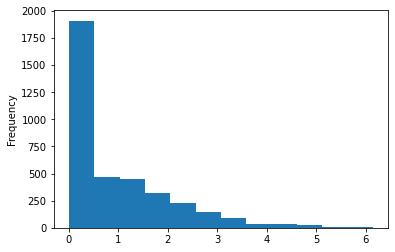

In [105]:
df['log_emp'] = np.log(df['NumberofEmployees']+1)
duplicates.groupby('id')['log_emp'].mean().plot.hist(bins=12)

<AxesSubplot:ylabel='Frequency'>

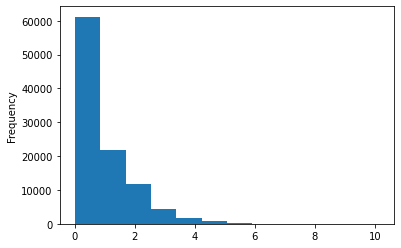

In [107]:
df.loc[~df['id'].isin(dup_ids)].groupby('id')['log_emp'].mean().plot.hist(bins=12)

In [41]:
df['ln_no_year'] = df['LicenceNumber'].str[3:].str.strip()
issued = df.loc[df['Status'] == 'Issued']
issued['lic_dups'] = issued['ln_no_year'].duplicated(keep=False)
issued.loc[issued['lic_dups']].sort_values(['ln_no_year', 'FOLDERYEAR']).head(10)


,FOLDERYEAR,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,...,Province,Country,PostalCode,LocalArea,NumberofEmployees,FeePaid,ExtractDate,Geom,ln_no_year,lic_dups
125314,14,2098472,14-100127,0,Zenergy Electric Ltd,NaN,Issued,2013-10-02T12:41:09-07:00,2014-12-31,Electrical Contractor,...,BC,CA,NaN,Killarney,1.0,129.0,2019-07-21T13:49:09-07:00,NaN,100127,True
26720,17,2776396,17-100127,0,Our Lady of Sorrows Church Society,NaN,Issued,2017-02-28T12:39:32-08:00,2017-12-31,Assembly Hall,...,BC,CA,V6B 2A7,Hastings-Sunrise,9.0,179.0,2020-01-01T02:32:01-08:00,"{""type"": ""Point"", ""coordinates"": [-123.0501537...",100127,True
92545,14,2098516,14-100128,0,Vancouver Quality Home Air Systems Ltd,NaN,Issued,2013-10-02T14:44:36-07:00,2014-12-31,Contractor - Special Trades,...,BC,CA,NaN,Renfrew-Collingwood,0.0,157.0,2019-07-21T13:49:09-07:00,NaN,100128,True
303376,17,2776397,17-100128,0,Canadian Mortgage & Housing Corporation,Performance Works,Issued,2016-11-18T12:33:15-08:00,2017-12-31,Assembly Hall,...,BC,CA,V6H 3R8,Fairview,10.0,139.0,2020-01-01T02:32:01-08:00,"{""type"": ""Point"", ""coordinates"": [-123.1317825...",100128,True
243175,14,2098980,14-100129,0,MLG Construction Limited,NaN,Issued,2013-10-03T11:56:45-07:00,2014-12-31,Office,...,BC,CA,NaN,Hastings-Sunrise,1.0,129.0,2019-07-21T13:49:09-07:00,NaN,100129,True
159661,17,2776398,17-100129,0,Meridian Cultural Society,NaN,Issued,2017-01-06T09:56:20-08:00,2017-12-31,Assembly Hall,...,BC,CA,V5N 4N5,Kensington-Cedar Cottage,0.0,139.0,2020-01-01T02:32:01-08:00,"{""type"": ""Point"", ""coordinates"": [-123.0647082...",100129,True
243178,14,2098997,14-100130,0,Milton Michael Sorokin (Milton Sorokin),Holly West Electric Co,Issued,2013-10-03T12:39:49-07:00,2014-12-31,Electrical Contractor,...,BC,CA,NaN,Riley Park,1.0,129.0,2019-07-21T13:49:09-07:00,NaN,100130,True
303377,17,2776399,17-100130,0,RMR Vancouver Station Ltd,Rocky Mountaineer Vacations,Issued,2016-12-19T13:29:53-08:00,2017-12-31,Assembly Hall,...,BC,CA,V6A 2L8,Strathcona,35.0,139.0,2020-01-01T02:32:01-08:00,"{""type"": ""Point"", ""coordinates"": [-123.0908114...",100130,True
92559,14,2099514,14-100131,0,Naam Developments Ltd,NaN,Issued,2013-10-04T13:10:42-07:00,2014-12-31,Contractor,...,BC,CA,NaN,Oakridge,2.0,157.0,2019-07-21T13:49:09-07:00,NaN,100131,True
26722,17,2776400,17-100131,0,The Association Of United Ukrainian Canadians,NaN,Issued,2016-12-30T10:09:06-08:00,2017-12-31,Assembly Hall,...,BC,CA,V6E 1V9,Strathcona,0.0,139.0,2020-01-01T02:32:01-08:00,"{""type"": ""Point"", ""coordinates"": [-123.0870172...",100131,True


In [53]:
df.loc[df['BusinessName'].notnull()].sort_values('BusinessName').head(20)

,FOLDERYEAR,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,...,City,Province,Country,PostalCode,LocalArea,NumberofEmployees,FeePaid,ExtractDate,Geom,ln_no_year
425935,18,3100450,18-516072,0,!Exotics BySIYTHE Corporation,NaN,Issued,2018-02-14T09:40:11-08:00,2018-12-31,Office,...,Vancouver,BC,CA,V6B 2Z4,Downtown,1.0,189.0,2020-11-01T02:32:31-08:00,"{""type"": ""Point"", ""coordinates"": [-123.1119263...",516072
365017,19,3265242,19-139570,0,!Exotics BySIYTHE Corporation,NaN,Pending,2019-08-15T10:17:53-07:00,2019-12-31,Office,...,Vancouver,BC,CA,V6B 2Z4,Downtown,1.0,50.0,2020-11-01T02:32:36-08:00,"{""type"": ""Point"", ""coordinates"": [-123.1119263...",139570
241092,14,2154232,14-141822,0,#1 Antique Warehouse Furnishings Ltd,#1 Antique Warehouse Furnishing,Issued,2013-12-12T14:12:39-08:00,2014-12-31,Retail Dealer,...,Vancouver,BC,CA,V5X 2R5,Marpole,6.0,130.0,2019-07-21T13:49:12-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1107282...",141822
226175,13,1813121,13-193702,0,#1 Antique Warehouse Furnishings Ltd,#1 Antique Warehouse Furnishing,Issued,2012-12-16T15:57:15-08:00,2013-12-31,Retail Dealer,...,Vancouver,BC,CA,V5X 2R5,Marpole,6.0,129.0,2019-07-21T13:49:08-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1107282...",193702
354375,18,3035854,18-467546,0,#1 Antique Warehouse Furnishings Ltd,#1 Antique Warehouse Furnishing,Issued,2018-02-15T17:16:23-08:00,2018-12-31,Retail Dealer,...,Vancouver,BC,CA,V5X 2R5,Marpole,8.0,185.0,2020-11-01T02:32:29-08:00,"{""type"": ""Point"", ""coordinates"": [-123.1107282...",467546
18689,16,2600156,16-141326,0,#1 Antique Warehouse Furnishings Ltd,#1 Antique Warehouse Furnishing,Issued,2015-12-22T17:38:02-08:00,2016-12-31,Retail Dealer,...,Vancouver,BC,CA,V5X 2R5,Marpole,5.0,136.0,2019-07-21T13:49:20-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1107282...",141326
366216,19,3269841,19-144084,0,#1 Antique Warehouse Furnishings Ltd,#1 Antique Warehouse Furnishing,Issued,2019-02-01T14:19:41-08:00,2019-12-31,Retail Dealer,...,Vancouver,BC,CA,V5X 2R5,Marpole,4.0,191.0,2020-11-01T02:32:36-08:00,"{""type"": ""Point"", ""coordinates"": [-123.1107282...",144084
63768,17,2815952,17-139639,0,#1 Antique Warehouse Furnishings Ltd,#1 Antique Warehouse Furnishing,Issued,2016-12-02T17:36:00-08:00,2017-12-31,Retail Dealer,...,Vancouver,BC,CA,V5X 2R5,Marpole,5.0,139.0,2020-01-01T02:32:04-08:00,"{""type"": ""Point"", ""coordinates"": [-123.1107282...",139639
108003,15,2371614,15-141890,0,#1 Antique Warehouse Furnishings Ltd,#1 Antique Warehouse Furnishing,Issued,2014-12-17T12:50:21-08:00,2015-12-31,Retail Dealer,...,Vancouver,BC,CA,V5X 2R5,Marpole,6.0,133.0,2019-07-21T13:49:16-07:00,"{""type"": ""Point"", ""coordinates"": [-123.1107282...",141890
451807,20,3499427,20-146214,0,#1 Antique Warehouse Furnishings Ltd,#1 Antique Warehouse Furnishing,Issued,2019-12-14T15:35:48-08:00,2020-12-31,Retail Dealer,...,Vancouver,BC,CA,V5X 2R5,Marpole,7.0,155.0,2020-11-15T00:09:32-08:00,"{""type"": ""Point"", ""coordinates"": [-123.1107282...",146214


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509444 entries, 0 to 509443
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   FOLDERYEAR             509444 non-null  int64  
 1   LicenceRSN             509444 non-null  int64  
 2   LicenceNumber          509444 non-null  object 
 3   LicenceRevisionNumber  509444 non-null  int64  
 4   BusinessName           493514 non-null  object 
 5   BusinessTradeName      207726 non-null  object 
 6   Status                 509444 non-null  object 
 7   IssuedDate             424090 non-null  object 
 8   ExpiredDate            423765 non-null  object 
 9   BusinessType           509444 non-null  object 
 10  BusinessSubType        277373 non-null  object 
 11  Unit                   136789 non-null  object 
 12  UnitType               136748 non-null  object 
 13  House                  286350 non-null  object 
 14  Street                 286363 non-nu

In [6]:
df['Status'].value_counts()

Issued                  404179
Pending                  42917
Gone Out of Business     39868
Inactive                 12187
Cancelled                10293
Name: Status, dtype: int64

In [19]:
set([x[:10] for x in df['ExtractDate'].unique()])

{'2019-07-21', '2020-01-01', '2020-11-01', '2020-11-15'}

In [23]:
df['extract_date'] = df['ExtractDate'].str[:10]
df.groupby(['extract_date', 'FOLDERYEAR'])['LicenceRSN'].count().unstack(level=0)

extract_date,2019-07-21,2020-01-01,2020-11-01,2020-11-15
FOLDERYEAR,,,,
13,60915.0,NaN,NaN,NaN
14,60581.0,NaN,NaN,NaN
15,60938.0,NaN,NaN,NaN
16,61394.0,NaN,NaN,NaN
17,NaN,60060.0,NaN,NaN
18,NaN,NaN,66180.0,NaN
19,NaN,NaN,70775.0,NaN
20,NaN,NaN,NaN,68601.0


According to the documentation, `ExtractDate` is the date that the data was extracted from the source table. From the above, we can see that only the last three years were extracted recently. This means any company established in 2016 or earlier that went out of busines since July 2019 will be wrongly listed as still being active. As a result, we'll probably see a lower share of out of inactive businesses than actually exist.

In [12]:
df['FOLDERYEAR'].value_counts().sort_index(ascending=False)

20    68601
19    70775
18    66180
17    60060
16    61394
15    60938
14    60581
13    60915
Name: FOLDERYEAR, dtype: int64

In [30]:
#df['IssuedDate'] = pd.to_datetime(df['IssuedDate'].str.split('T').str[0])
df['ExpiredDate'] = pd.to_datetime(df['ExpiredDate'])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509444 entries, 0 to 509443
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   FOLDERYEAR             509444 non-null  int64         
 1   LicenceRSN             509444 non-null  int64         
 2   LicenceNumber          509444 non-null  object        
 3   LicenceRevisionNumber  509444 non-null  int64         
 4   BusinessName           493514 non-null  object        
 5   BusinessTradeName      207726 non-null  object        
 6   Status                 509444 non-null  object        
 7   IssuedDate             424090 non-null  datetime64[ns]
 8   ExpiredDate            423765 non-null  datetime64[ns]
 9   BusinessType           509444 non-null  object        
 10  BusinessSubType        277373 non-null  object        
 11  Unit                   136789 non-null  object        
 12  UnitType               136748 non-null  obje

In [12]:
status = df.groupby('FOLDERYEAR')['Status'].value_counts()

In [13]:
status = status.reset_index(name='count')

<AxesSubplot:xlabel='FOLDERYEAR'>

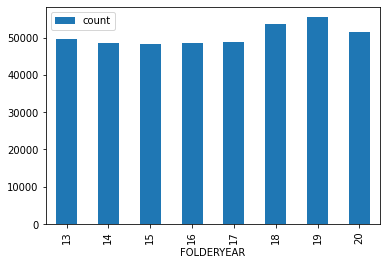

In [15]:
status.loc[status['Status']=='Issued'].plot(x='FOLDERYEAR', y='count', kind='bar')

<AxesSubplot:xlabel='FOLDERYEAR'>

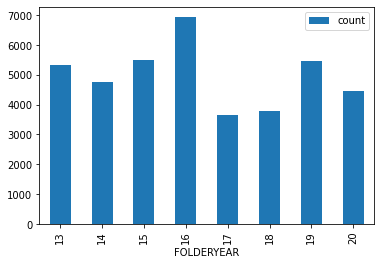

In [16]:
status.loc[status['Status']=='Gone Out of Business'].plot(x='FOLDERYEAR', y='count', kind='bar')

In [45]:
df['LicenceNumber'].duplicated().sum()

11630